<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mobile-app-analysis" data-toc-modified-id="Mobile-app-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mobile app analysis</a></span><ul class="toc-item"><li><span><a href="#Общая-информация" data-toc-modified-id="Общая-информация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Общая информация</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#Анализ-результатов-эксперимента" data-toc-modified-id="Анализ-результатов-эксперимента-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Анализ результатов эксперимента</a></span><ul class="toc-item"><li><span><a href="#A/A-тест" data-toc-modified-id="A/A-тест-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>A/A тест</a></span></li><li><span><a href="#A/B-тест" data-toc-modified-id="A/B-тест-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>A/B тест</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

# Mobile app analysis

**В ходе исследования предстоит:**
- разобраться, как ведут себя пользователи нашего мобильного приложения по продаже продуктов питания;
- изучить воронку продаж;
- исследовать результаты A/A/B-эксперимента.

**Гипотеза:** изменить шрифт текста во всём приложении.

`logs_exp.csv` — логи за время эксперимента. Каждая запись — это действие пользователя, или событие.

**Описание данных:**
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Общая информация

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt

In [2]:
# прочитаем датасет
try:
    df = pd.read_csv('logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Подготовка данных

In [4]:
# переименуем столбцы
df = df.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_time',
    'ExpId': 'group'
})

In [5]:
# приведём unix time к формату даты и времени
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

# создадим столбец с датой
df['event_date'] = df['event_time'].dt.date

In [6]:
# пропуски
df.isna().sum()

event_name    0
device_id     0
event_time    0
group         0
event_date    0
dtype: int64

In [7]:
# дубликаты
df.duplicated().sum()

413

In [8]:
# удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [9]:
# уникальные события и группы
df.event_name.unique(), df.group.unique()

(array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
        'OffersScreenAppear', 'Tutorial'], dtype=object),
 array([246, 248, 247], dtype=int64))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


<div class='alert alert-info'><b>
    
- Переименовали столбцы
- Привели unix time к формату даты и времени
- Создадили столбец с датой
- Пропусков нет
- Дубликаты удалили 413
</b></div>

## Анализ данных

**Изучим** более подробно данные о событиях, пользователях и о времени проведения эксперимента

In [11]:
events_count = len(df)
users_count = len(df.device_id.unique())
print(f'Всего событий - {events_count}',
      f'Всего пользователей - {users_count}',
      f'Событий в среднем на одного пользователя - {round(events_count/users_count)}', sep='\n')

Всего событий - 243713
Всего пользователей - 7551
Событий в среднем на одного пользователя - 32


In [12]:
print(f'Минимальная дата - {df.event_date.min()}',
      f'Максимальная дата - {df.event_date.max()}', sep='\n')

Минимальная дата - 2019-07-25
Максимальная дата - 2019-08-07


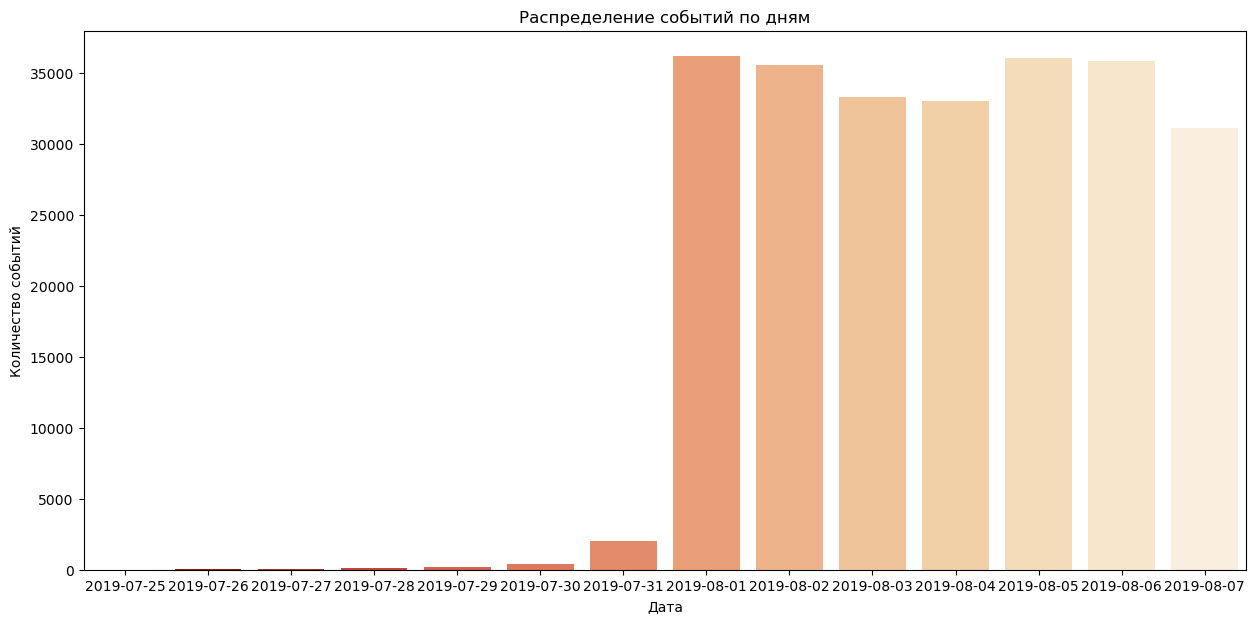

In [13]:
plt.figure(figsize=(15, 7))
sns.barplot(x='event_date',
            y='event_name',
            data=df.groupby('event_date')[['event_name']].count().reset_index(),
            palette='OrRd_r')
plt.title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

Имеются данные за 2 недели - с 25 июля по 07 августа 2019 года. Наблюдаем резкий скачок 1 августа, поэтому оставим данные за последнюю неделю, так как слишком большая разница в наблюдениях исказит результаты исследования.

---

In [14]:
# фильтруем данные, оставляя последнюю неделю наблюдений
df_lw = df.query('event_date >= datetime(2019, 8, 1).date()')

In [15]:
print(f'Событий отфильтровано - {(1 - len(df_lw)/len(df)):.2%} = {len(df) - len(df_lw)}',
      f'Пользователей отфильтровано - {(1 - len(df_lw.device_id.unique())/len(df.device_id.unique())):.2%} =\
 {len(df.device_id.unique()) - len(df_lw.device_id.unique())}', sep='\n')

Событий отфильтровано - 1.16% = 2826
Пользователей отфильтровано - 0.23% = 17


In [16]:
# количество пользователей по группам
df_lw.groupby('group')[['device_id']].nunique()

,device_id
group,
246,2484
247,2513
248,2537


<div class='alert alert-info'><b>
    
Изучив и отфильтровав данные, получаем:
    
- наблюдения с 1 по 7 августа включительно;
- 98.84% событий (удалено 1.16%=2826 событий);
- 99.77% пользователей (удалено 0.23%=17 пользователей).
</b></div>

## Воронка событий

Есть 5 видов событий:
- MainScreenAppear - главный экран;
- OffersScreenAppear - предложения;
- CartScreenAppear - корзина;
- PaymentScreenSuccessful - успешная оплата;
- Tutorial - обучение.

In [17]:
# количетво событий по видам и их процент от общего количества
events = pd.DataFrame()
events['count'] = df_lw.groupby('event_name')['device_id'].count()
events['percentage'] = events['count']/len(df_lw)
events.sort_values(by='count', ascending=False).style.format({'percentage': '{:.2%}'})

,count,percentage
event_name,,
MainScreenAppear,117328,48.71%
OffersScreenAppear,46333,19.23%
CartScreenAppear,42303,17.56%
PaymentScreenSuccessful,33918,14.08%
Tutorial,1005,0.42%


In [18]:
# количетво пользователей, совершивших данное событие и процент от общего количества пользователей
event_users = pd.DataFrame()
event_users['count'] = df_lw.groupby('event_name')['device_id'].nunique()
event_users['percentage'] = event_users['count']/df_lw['device_id'].nunique()
event_users = event_users.sort_values(by='count', ascending=False).reset_index()
event_users.style.format({'percentage': '{:.2%}'})

,event_name,count,percentage
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


Можно предположить, что события происходят в следующем порядке:
1. Посещение главного экрана
2. Посещение страницы с предложениями
3. Посещение корзины
4. Отображение информации об успешной оплате

Этап обучения мало кто проходит, значит он необязателен. Исключим его из воронки событий

---

In [19]:
# создадим столбец с долей пользователей предыдущего события
event_users['funnel'] = 1
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = event_users.loc[i, 'count'] /  (event_users.loc[i-1, 'count'])

event_users[0:4].style.format({'percentage': '{:.2%}', 'funnel': '{:.2%}'})

,event_name,count,percentage,funnel
0,MainScreenAppear,7419,98.47%,100.00%
1,OffersScreenAppear,4593,60.96%,61.91%
2,CartScreenAppear,3734,49.56%,81.30%
3,PaymentScreenSuccessful,3539,46.97%,94.78%


<div class='alert alert-info'><b>

- На 1 шаге теряется больше всего пользователей ~38%, то есть при переходе с главного экрана на страницу с предложениями.
- На 2 шаге, при переходе в корзину, теряется ~19%.
- На 3 шаге, из корзины к успешной оплате, ~5%

Только 47% пользователей доходят от первого события до оплаты.
</b></div>

## Анализ результатов эксперимента

### A/A тест

Проверим различия между контрольными группами

**Критерии успешного A/A-теста:**
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [20]:
# количество пользователей по группам
df_lw.groupby('group')[['device_id']].nunique()

,device_id
group,
246,2484
247,2513
248,2537


In [21]:
display(f"Количество пользователей между группами различается на \
{1 - df_lw.query('group == 246').device_id.nunique()/df_lw.query('group == 247').device_id.nunique():.2%}")

'Количество пользователей между группами различается на 1.15%'

Разница несущественная, поэтому принимаем критерий

---

In [22]:
len(df_lw.groupby('device_id')['group'].nunique().reset_index().query('group > 1'))

0

Пользователей, которые присутствуют в более чем одной группе, нет

---

За ключевую метрику примем конверсию в оплату. Но сначала создадим сводную таблицу с количеством пользователей по группам и событиям. А также функцию, проверяющую различия между группами по событиям статистическим z-критерием.

**H0: различий по группам нет**  
**H1: различия по группам есть**

In [23]:
# сводная таблица
event_users_grouped = df_lw.pivot_table(
    index='event_name', columns='group', values='device_id', aggfunc='nunique', margins=True)\
    .reset_index().sort_values('All', ascending=False).reset_index(drop=True)

event_users_grouped = event_users_grouped.reindex([1, 2, 3, 4, 5, 0]).reset_index(drop=True)
event_users_grouped

group,event_name,246,247,248,All
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,Tutorial,278,283,279,840
5,All,2484,2513,2537,7534


In [24]:
def stat(successes1, successes2, trials1, trials2):
    alpha = 0.05
    event_name = ['MainScreenAppear', 'OffersScreenAppear',
              'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2 
    z_value = difference / (p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) ** 0.5
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if p_value < alpha:
        print(event_name[i], round(p_value, 4), '- Отвергаем нулевую гипотезу')
    else:
        print(event_name[i], round(p_value, 4), '- Не отвергаем нулевую гипотезу')

In [25]:
f'Различие ключевых метрик по группам \
{event_users_grouped.iloc[3, 1]/event_users_grouped.iloc[5, 1] - event_users_grouped.iloc[3, 2]/event_users_grouped.iloc[5, 2]:.2%}'

'Различие ключевых метрик по группам 2.23%'

In [26]:
# создадим цикл для 246 и 247 группы
for i in range(0, 5):
    stat(event_users_grouped.iloc[i, 1],
         event_users_grouped.iloc[i, 2],
         event_users_grouped.iloc[5, 1],
         event_users_grouped.iloc[5, 2])

MainScreenAppear 0.7571 - Не отвергаем нулевую гипотезу
OffersScreenAppear 0.2481 - Не отвергаем нулевую гипотезу
CartScreenAppear 0.2288 - Не отвергаем нулевую гипотезу
PaymentScreenSuccessful 0.1146 - Не отвергаем нулевую гипотезу
Tutorial 0.9377 - Не отвергаем нулевую гипотезу


<div class='alert alert-info'><b>
    
- Количество пользователей между группами различается на 1.15%.
- Различие ключевых метрик по группам 2.23%, но статистической значимости не обнаружено, как и по другим событиям.
- Пользователей, которые присутствуют в более чем одной группе, нет.    
    
Статистическая значимость различий между группами A/A не обнаружена.  
Разбивка по группам работаем корректно.
</b></div>

### A/B тест

Проверим различия между контрольными и тестовой группой. А также с объединённой контрольной группой и сравним результаты.

**H0: различий по группам нет**  
**H1: различия по группам есть**

In [27]:
# создадим цикл для 247 и 248 группы
for i in range(0, 5):
    stat(event_users_grouped.iloc[i, 2],
         event_users_grouped.iloc[i, 3],
         event_users_grouped.iloc[5, 2],
         event_users_grouped.iloc[5, 3])

MainScreenAppear 0.4587 - Не отвергаем нулевую гипотезу
OffersScreenAppear 0.9198 - Не отвергаем нулевую гипотезу
CartScreenAppear 0.5786 - Не отвергаем нулевую гипотезу
PaymentScreenSuccessful 0.7373 - Не отвергаем нулевую гипотезу
Tutorial 0.7653 - Не отвергаем нулевую гипотезу


In [28]:
# создадим цикл для 246 и 248 группы
for i in range(0, 5):
    stat(event_users_grouped.iloc[i, 1],
         event_users_grouped.iloc[i, 3],
         event_users_grouped.iloc[5, 1],
         event_users_grouped.iloc[5, 3])

MainScreenAppear 0.295 - Не отвергаем нулевую гипотезу
OffersScreenAppear 0.2084 - Не отвергаем нулевую гипотезу
CartScreenAppear 0.0784 - Не отвергаем нулевую гипотезу
PaymentScreenSuccessful 0.2123 - Не отвергаем нулевую гипотезу
Tutorial 0.8264 - Не отвергаем нулевую гипотезу


Значимых различий не наблюдается

---

In [29]:
# создадим столбец с объединёнными данными контрольных групп
event_users_grouped['A+A'] = event_users_grouped[246] + event_users_grouped[247]
event_users_grouped

group,event_name,246,247,248,All,A+A
0,MainScreenAppear,2450,2476,2493,7419,4926
1,OffersScreenAppear,1542,1520,1531,4593,3062
2,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358
4,Tutorial,278,283,279,840,561
5,All,2484,2513,2537,7534,4997


In [30]:
# создадим цикл для 248 и A+A группы
for i in range(0, 5):
    stat(event_users_grouped.iloc[i, 3],
         event_users_grouped.iloc[i, 5],
         event_users_grouped.iloc[5, 3],
         event_users_grouped.iloc[5, 5])

MainScreenAppear 0.2942 - Не отвергаем нулевую гипотезу
OffersScreenAppear 0.4343 - Не отвергаем нулевую гипотезу
CartScreenAppear 0.1818 - Не отвергаем нулевую гипотезу
PaymentScreenSuccessful 0.6004 - Не отвергаем нулевую гипотезу
Tutorial 0.7649 - Не отвергаем нулевую гипотезу


Наблюдаются различия в статистических показателях при проверке как одной контрольной группы с тестовой, так и другой. А также с объединёнными контрольными даными. НО ни в одном случае стат значимость не обнаружена.

---

<div class='alert alert-info'><b>
    
Всего получилось 20 проверок. Согласно поправке Бонферрони разделим принятый уровень значимости на число сравнений. Следовательно уровень значимости alpha будет равен 0.0025.  
    Все значения гораздо больше этого уровня. Значит различий между группами нет и шрифт текста никак не влияет.
</b></div>

## Вывод

Изучив поведение пользователей, воронку продаж и результаты эксперимента, можно заключить следующее:
- A/A/B тест сработал корректно.
- Статистически значимых различий между группами не обнаружено, а значит изменение шрифта в приложении никак не повлияло на его работу.
- Почти 38% теряется при переходе с главного экрана на страницу с предложениями. Следует обратить внимание на этот этап и принять меры, что может привести к увеличению конверсии в покупку.